(GLM-binomial-regression)=
# Binomial regression

:::{post} February, 2022
:tags: binomial regression, generalized linear model, 
:category: beginner
:author: Benjamin T. Vincent
:::

This notebook covers the logic behind [Binomial regression](https://en.wikipedia.org/wiki/Binomial_regression), a specific instance of Generalized Linear Modelling. The example is kept very simple, with a single predictor variable. 

It helps to recap logistic regression to understand when binomial regression is applicable. Logistic regression is useful when your outcome variable is a set of successes or fails, that is, a series of `0`, `1` observations. An example of this kind of outcome variable is "Did you go for a run today?" Binomial regression (aka aggregated binomial regression) is useful when you have a certain number of successes out of $n$ trials. So the example would be, "How many days did you go for a run in the last 7 days?" 

The observed data are a set of _counts_ of number of successes out of $n$ total trials. Many people might be tempted to reduce this data to a proportion, but this is not necessarily a good idea. For example, proportions are not directly measured, they are often best treated as latent variables to be estimated. Also, a proportion looses information: a proportion of 0.5 could respond to 1 run out of 2 days, or to 4 runs in the last 4 weeks, or many other things, but you have lost that information by paying attention to the proportion alone. 

The appropriate likelihood for binomial regression is the Binomial distribution:

$$
y_i \sim \text{Binomial}(n, p_i)
$$

where $y_i$ is a count of the number of successes out of $n$ trials, and $p_i$ is the (latent) probability of success. What we want to achieve with Binomial regression is to use a linear model to accurately estimate $p_i$ (i.e. $p_i = \beta_0 + \beta_1 \cdot x_i$). So we could try to do this with a likelihood term like:

$$
y_i \sim \text{Binomial}(n, \beta_0 + \beta_1 \cdot x_i)
$$

If we did this, we would quickly run into problems when the linear model generates values of $p$ outside the range of $0-1$. This is where the link function comes in:

$$
g(p_i) = \beta_0 + \beta_1 \cdot x_i
$$

where $g()$ is a link function. This can be thought of as a transformation that maps proportions in the range $(0, 1)$ to the domain $(-\infty, +\infty)$. There are a number of potential functions that could be used, but a common one to use is the [Logit function](https://en.wikipedia.org/wiki/Logit).

Although what we actually want to do is to rearrange this equation for $p_i$ so that we can enter it into the likelihood function. This results in:

$$
p_i= g^{-1}(\beta_0 + \beta_1 \cdot x_i)
$$

where $g^{-1}()$ is the inverse of the link function, in this case the inverse of the Logit function (i.e. the [logistic sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) function, also known as the expit function). So if we enter this into our likelihood function we end up with:

$$
y_i \sim \text{Binomial}(n, \text{InverseLogit}(\beta_0 + \beta_1 \cdot x_i))
$$

This defines our likelihood function. All you need now to get some Bayesian Binomial regression done is priors over the $\beta$ parameters. The observed data are $y_i$, $n$, and $x_i$.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.special import expit

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

## Generate data

In [3]:
# true params
beta0_true = 0.7
beta1_true = 0.4
# number of yes/no questions
n = 20

sample_size = 30
x = np.linspace(-10, 20, sample_size)
# Linear model
mu_true = beta0_true + beta1_true * x
# transformation (inverse logit function = expit)
p_true = expit(mu_true)
# Generate data
y = rng.binomial(n, p_true)
# bundle data into dataframe
data = pd.DataFrame({"x": x, "y": y})

We can see that the underlying data $y$ is count data, out of $n$ total trials.

In [4]:
data.head()

,x,y
0,-10.000000,3
1,-8.965517,1
2,-7.931034,3
3,-6.896552,1
4,-5.862069,2


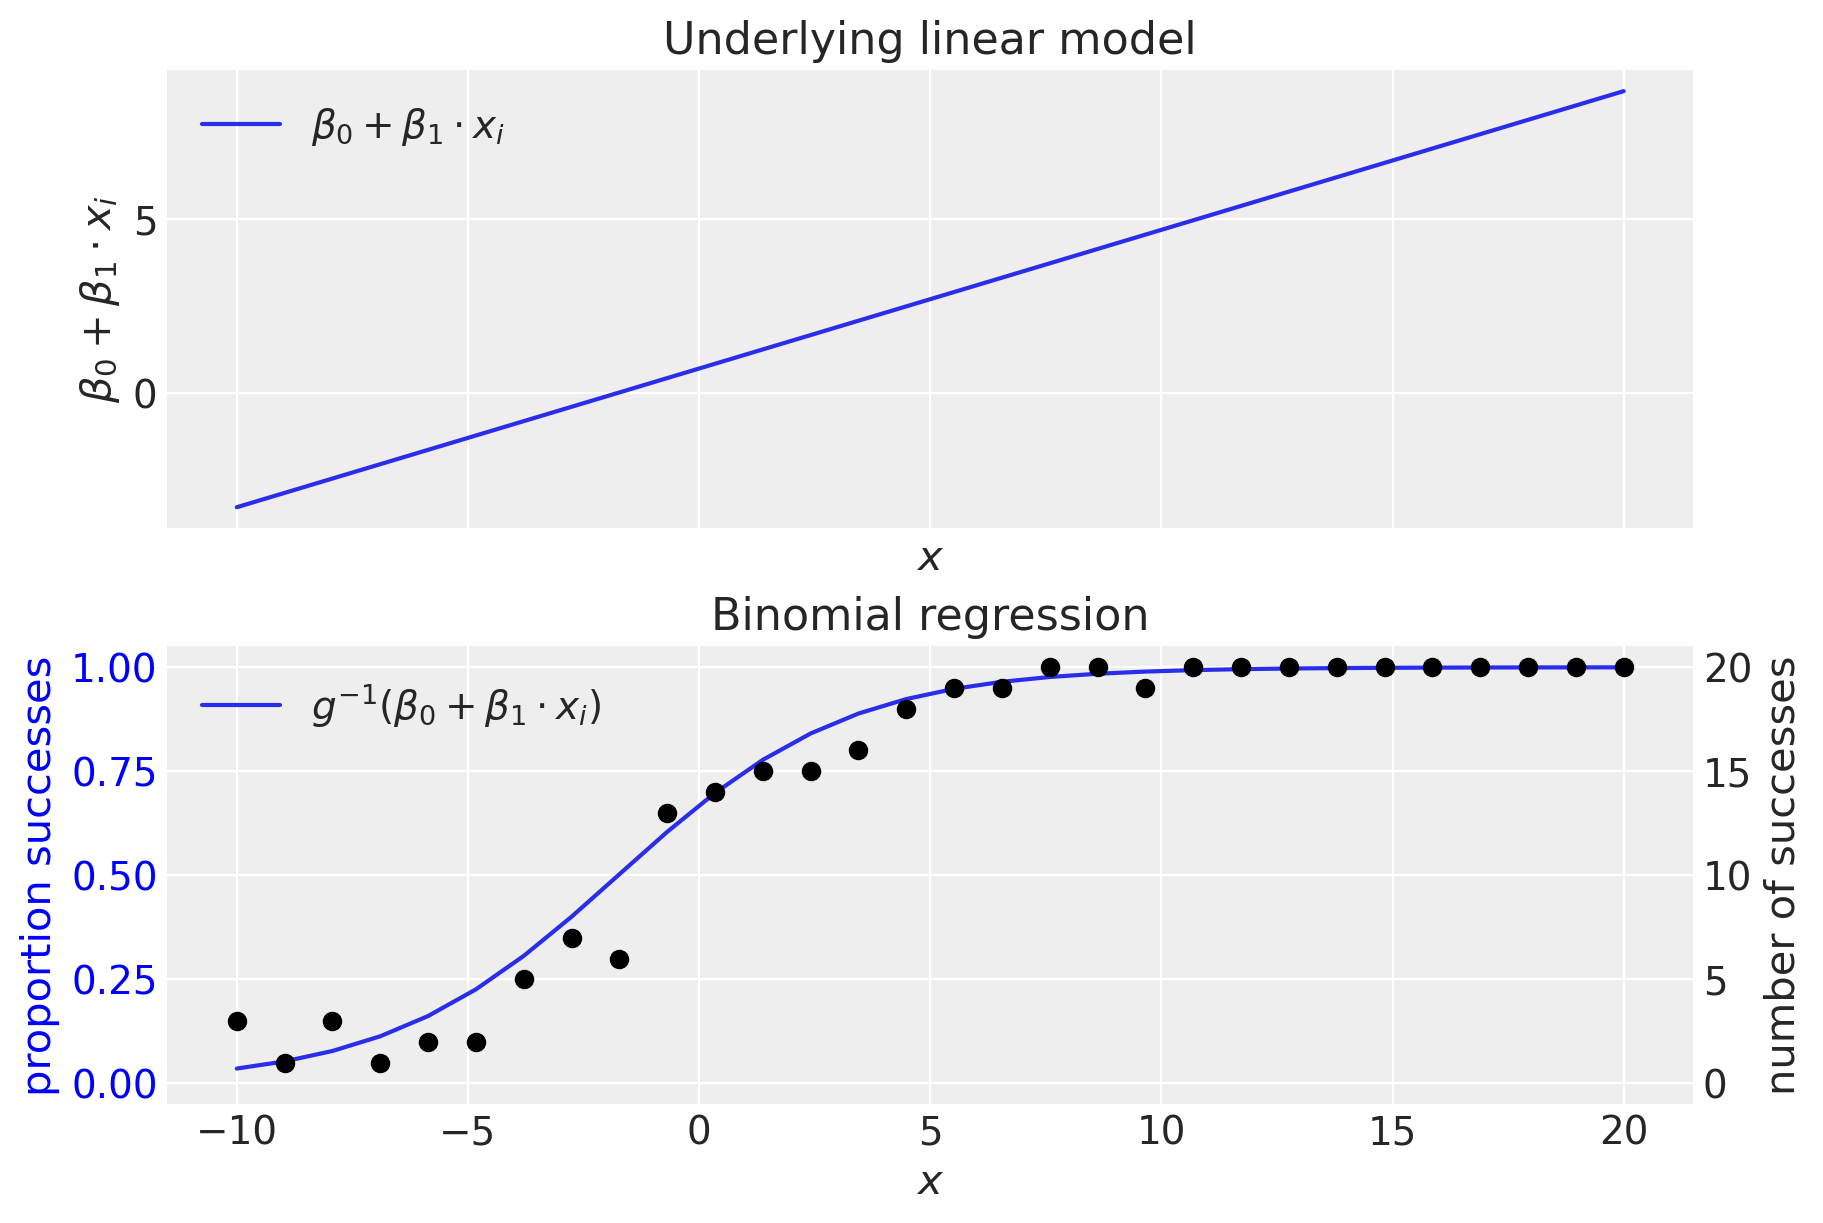

In [5]:
# Plot underlying linear model
fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
ax[0].plot(x, mu_true, label=r"$β_0 + β_1 \cdot x_i$")
ax[0].set(xlabel="$x$", ylabel=r"$β_0 + β_1 \cdot x_i$", title="Underlying linear model")
ax[0].legend()

# Plot GLM
freq = ax[1].twinx()  # instantiate a second axes that shares the same x-axis
freq.set_ylabel("number of successes")
freq.scatter(x, y, color="k")
# plot proportion related stuff on ax[1]
ax[1].plot(x, p_true, label=r"$g^{-1}(β_0 + β_1 \cdot x_i)$")
ax[1].set_ylabel("proportion successes", color="b")
ax[1].tick_params(axis="y", labelcolor="b")
ax[1].set(xlabel="$x$", title="Binomial regression")
ax[1].legend()
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[1].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)

The top panel shows the (untransformed) linear model. We can see that the linear model is generating values outside the range $0-1$, making clear the need for an inverse link function, $g^{-1}()$ which converts from the domain of $(-\infty, +\infty) \rightarrow (0, 1)$. As we've seen, this is done by the inverse logistic function (aka logistic sigmoid).

## Binomial regression model

Technically, we don't need to supply `coords`, but providing this (a list of observation values) helps when reshaping arrays of data later on. The information in `coords` is used by the `dims` kwarg in the model.

In [6]:
coords = {"observation": data.index.values}

with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.ConstantData("x", data["x"], dims="observation")
    # priors
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    # linear model
    mu = beta0 + beta1 * x
    p = pm.Deterministic("p", pm.math.invlogit(mu), dims="observation")
    # likelihood
    pm.Binomial("y", n=n, p=p, observed=data["y"], dims="observation")

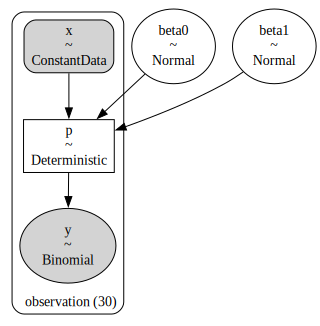

In [7]:
pm.model_to_graphviz(binomial_regression_model)

In [8]:
with binomial_regression_model:
    idata = pm.sample(1000, tune=2000)

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


Confirm no inference issues by visual inspection of chain. We've got no warnings about divergences, $\hat{R}$, or effective sample size. Everything looks good.

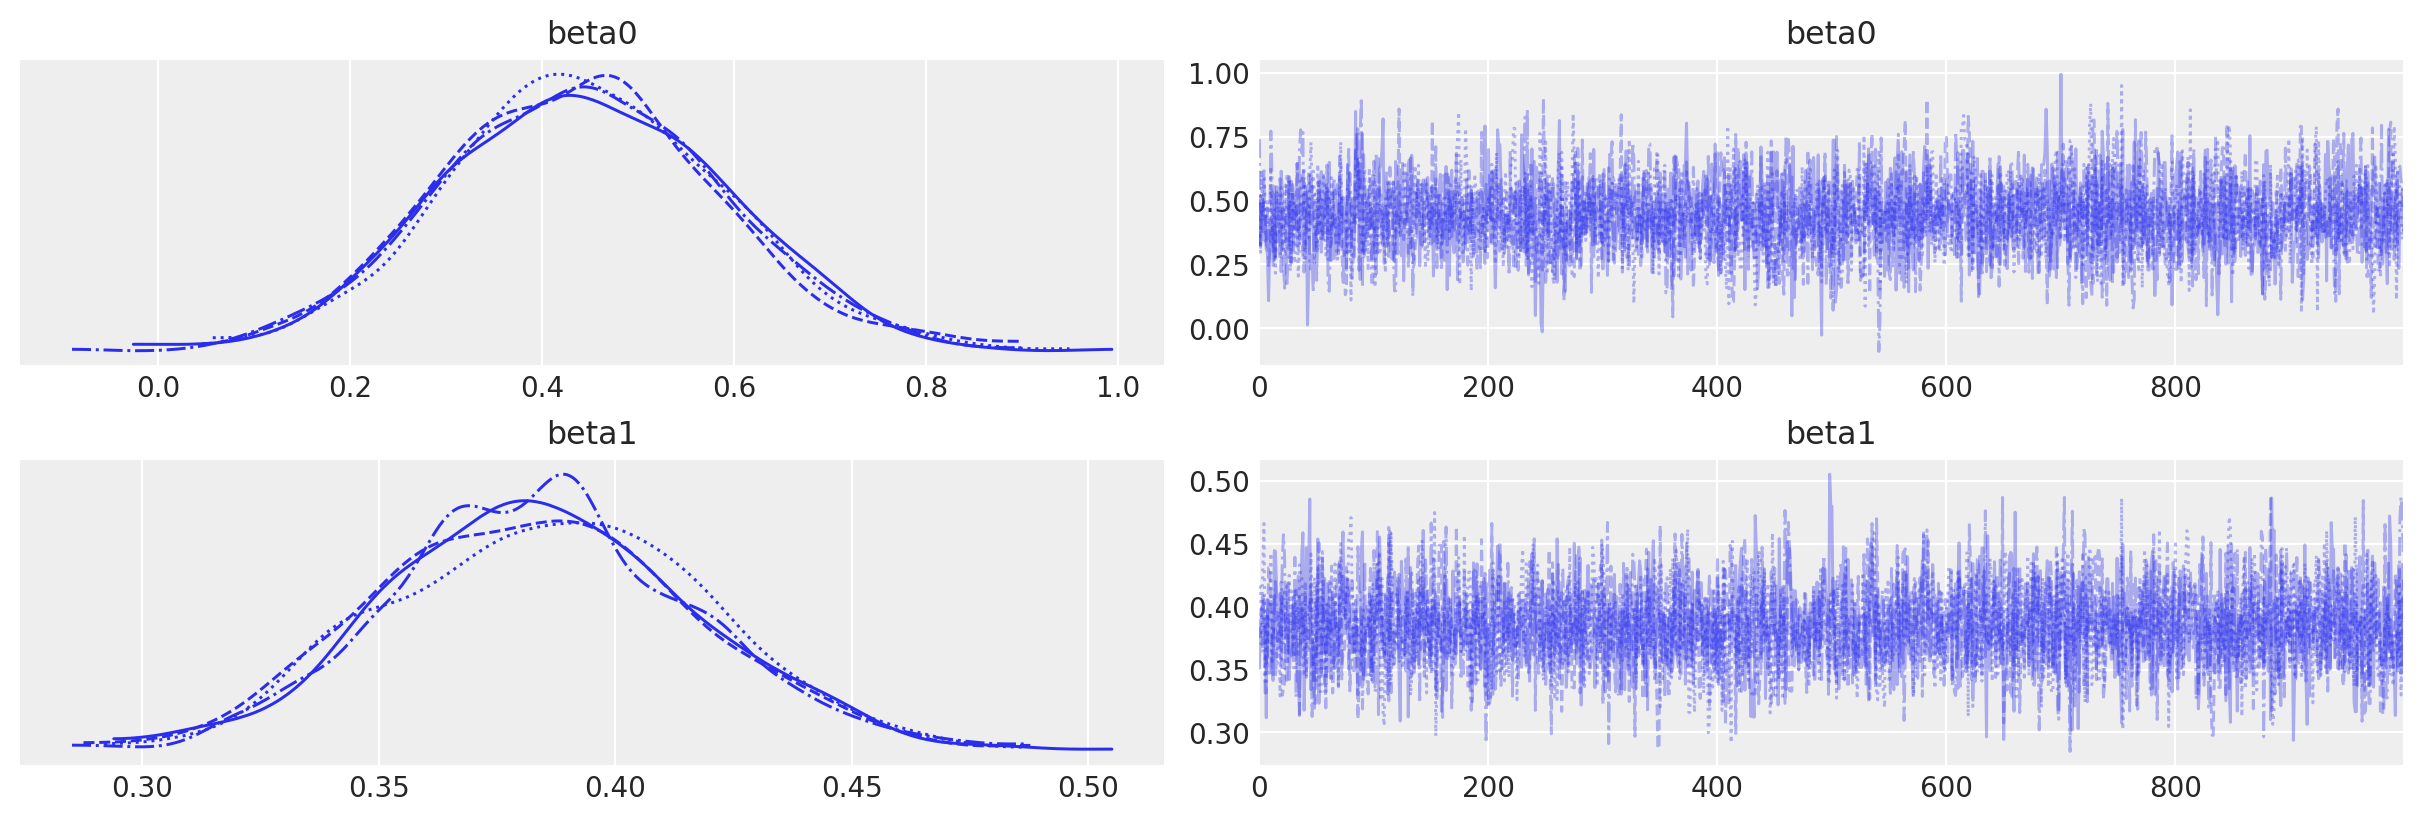

In [9]:
az.plot_trace(idata, var_names=["beta0", "beta1"]);

## Examine results
The code below plots out model predictions in data space, and our posterior beliefs in parameter space.

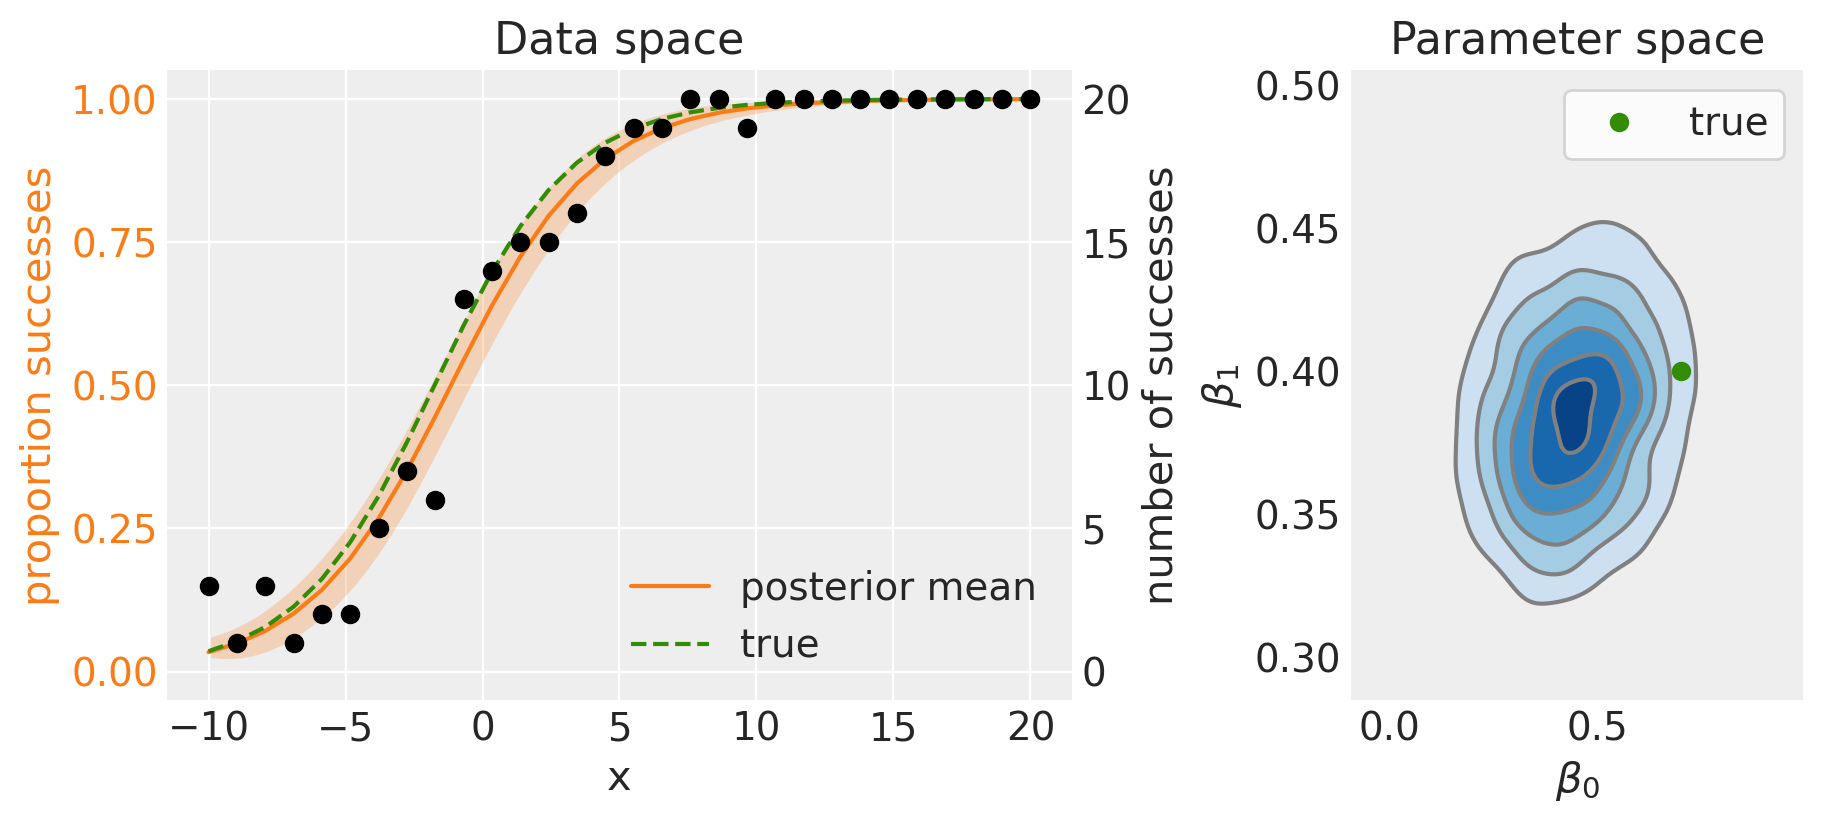

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax[0].plot(data["x"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], p_true, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of successes")
freq.scatter(data["x"], data["y"], color="k", label="data")
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, 20, 5) / n)
freq.set(yticks=np.linspace(0, 20, 5))

# Parameter space plot ===================================================
az.plot_kde(
    az.extract(idata, var_names="beta0"),
    az.extract(idata, var_names="beta1"),
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);

The left panel shows the posterior mean (solid line) and 95% credible intervals (shaded region). Because we are working with simulated data, we know what the true model is, so we can see that the posterior mean compares favourably with the true data generating model. 

This is also shown by the posterior distribution over parameter space (right panel), which does well when comparing to the true data generating parameters.

Using binomial regression in real data analysis situations would probably involve more predictor variables, and correspondingly more model parameters, but hopefully this example has demonstrated the logic behind binomial regression.

A good introduction to generalized linear models is provided by {cite:t}`roback2021beyond` which is available in hardcopy and [free online](https://bookdown.org/roback/bookdown-BeyondMLR/).

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in July 2021 
- Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) in February 2022
- Updated by Benjamin T. Vincent in February 2023 to run on PyMC v5
- Updated to use `az.extract` by [Benjamin T. Vincent](https://github.com/drbenvincent) in February 2023, ([pymc-examples#522](https://github.com/pymc-devs/pymc-examples/pull/522))

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl

Last updated: Sun Feb 05 2023

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.9.0

pytensor: 2.8.11
aeppl   : not installed

matplotlib: 3.6.3
numpy     : 1.24.1
arviz     : 0.14.0
pandas    : 1.5.3
pymc      : 5.0.1

Watermark: 2.3.1



:::{include} ../page_footer.md :::